In [3]:
import pymongo
import pandas as pd
import json
import db.knowhere_db as kdb

In [8]:
reader = kdb.Reader(db_name='knowhere')
data = reader.get_dataframe_pivoted('iphone_test3', username='emil', 
                                    min_date = '2017-03-19', max_date = '2017-03-20')
data.head()

,Altimeter (Barometer) Relative Altitude,Altimeter (Barometer) Pressure,Gravity z,Gravity y,Gravity x,Magnetometer z,Magnetometer x,Magnetometer y,Microphone Left Channel Level,Microphone Right Channel Level,...,Gyrometer y,Gyrometer x,Acceleration z,Acceleration x,Acceleration y,GPS Horizontal Accuracy,GPS Longitude,GPS Vertical Accuracy,GPS Latitude,GPS Altitude
2017-03-19 00:00:00,-6.153217,101.490303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-19 00:00:01,-6.099997,101.489655,NaN,NaN,NaN,-410.546692,2.057312,32.325836,-39.9762,-39.9762,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-19 00:00:02,-6.099997,101.489655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-19 00:00:03,-6.111042,101.489799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-19 00:00:04,-6.135143,101.490089,-0.99922,-0.000682,-0.039473,NaN,NaN,NaN,NaN,NaN,...,-0.019549,0.031855,-0.013322,-0.000673,-0.00005,NaN,NaN,NaN,NaN,NaN


### Plotting Functions

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
from datetime import datetime

In [11]:
def get_daily_data(day, user_id = kdb.ObjectId('58c5b91d71a9e82f33ad1669'), sensor = "GPS", collection = "iphone_test"):
    to_plot = reader.get_dataframe_pivoted(collection = collection, user_id = user_id, sensor = sensor)
    to_plot = to_plot.ix[day]
    to_plot = to_plot.astype(float)
    #plt.plot(to_plot['GPS (Latitude)'], to_plot['GPS (Longitude)'], zorder = 2)
    plt.scatter(to_plot['GPS (Latitude)'], to_plot['GPS (Longitude)'], zorder = 1, c = to_plot.index)
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    plt.title("Location Data for %s" % (day))
    

### Activity Measurement

In [7]:
t1 = reader.get_dataframe_pivoted(collection = 'iphone_test', sensor = "Acceleration")

db/knowhere_db.py:74: Warning: Excluding user_id from filter can cause errors during pivot
  warnings.warn('Excluding user_id from filter can cause errors during pivot', Warning)


In [8]:
t1 = t1.astype(float)

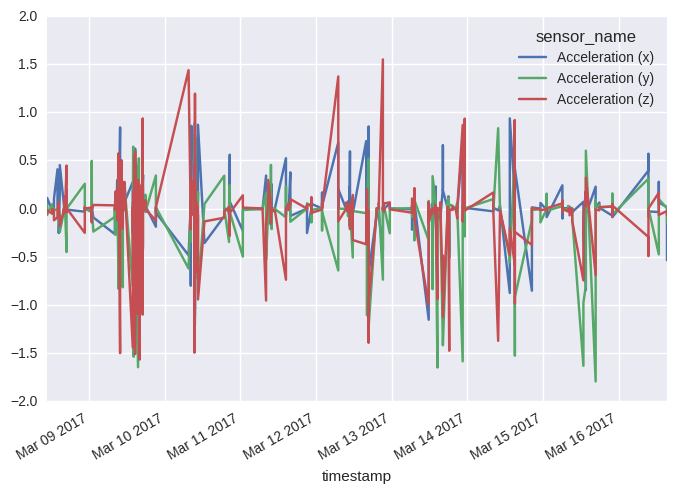

In [9]:
t1.plot()

In [10]:
from math import sqrt

accel_mag = []
for row in range(len(t1)):
    accel_mag.append(sqrt(t1.iloc[row, 0]**2 + t1.iloc[row, 1]**2 + t1.iloc[row, 2]**2))
    
t1['accel_mag'] = accel_mag

In [11]:
#check acceleration levels are various percentiles, just to see what's there
accel_thresholds = []

for quan in np.linspace(0, 1.0, 9):
    accel_thresholds.append((quan, t1['accel_mag'].quantile(q=quan)))
    
accel_thresholds

[(0.0, 0.0),
 (0.125, 0.005405385705153482),
 (0.25, 0.006505375143762363),
 (0.375, 0.007741483913662784),
 (0.5, 0.009681526024984075),
 (0.625, 0.013445551433988626),
 (0.75, 0.026667841227595288),
 (0.875, 0.08279523421398678),
 (1.0, 1.939071038049297)]

In [12]:
#set a threshold based on 1 day of Emil's data, ideally we'll set this based off of all user data
activity_threshold = 0.051845671879112265

In [13]:
def check_single_active(accel_mag, activity_threshold = 0.051845671879112265):
    if accel_mag >= activity_threshold:
        return 1
    else:
        return 0
    return 0


In [14]:
def check_active(mag_list):
    mag_list = list(mag_list)
    activity_raw = 0
    for active in mag_list:
        activity_raw += check_single_active(active)
    return float(activity_raw) / len(t1['accel_mag'])

In [15]:
check_active(t1['accel_mag'])

0.16596736596736597

# Emil Look Here!

### Distance Traveled

In [13]:
#Haversine Function, pulled from StackOverflow

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees, AKA Latitude / Longitude)

    All args must be of equal length.    

    """
    from math import radians, cos, sin, asin, sqrt

    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    #haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    miles = 3956 * c # Radius of earth in miles. Use 6370 for kilometers
    return miles

In [23]:
def distance_traveled(min_date, max_date, username):
    """
    Calculate the distance a user has traveled over a given date range. Involves all modes of transportation, 
    and is calculated using Great-circle distance.
    """
    
    #make DB query to get GPS data for specified day 
    day_dist = reader.get_dataframe_pivoted(collection = 'iphone_test3', sensor = "GPS", username = username,
                                min_date = min_date, max_date = max_date)
    day_dist = day_dist.astype(float)
    
    #Use haversine function to get distances between all GPS points
    dist_traveled = haversine(day_dist['GPS Longitude'].shift(), day_dist['GPS Latitude'].shift(), 
          day_dist.ix[1:, 'GPS Longitude'], day_dist.ix[1:, 'GPS Latitude'])
    
    return dist_traveled.sum()

In [24]:
distance_traveled("03-01-2017", "03-20-2017", "glen")

258.3755976361753

In [32]:
def daily_distance_traveled(day, username):
    #Get day after day passed into function so that DB call works
    import pandas.tseries.offsets as pdo
    next_day = pd.to_datetime(day) + pdo.Day()
    
    #make DB query to get GPS data for specified day 
    day_dist = reader.get_dataframe_pivoted(collection = 'iphone_test3', sensor = "GPS", username = username,
                                min_date = str(day), max_date = str(next_day))
    day_dist = day_dist.astype(float)
    
    dist_traveled = haversine(day_dist['GPS Longitude'].shift(), day_dist['GPS Latitude'].shift(), 
          day_dist.ix[1:, 'GPS Longitude'], day_dist.ix[1:, 'GPS Latitude'])
    dt = dist_traveled.sum()
    return dt

In [37]:
daily_distance_traveled('03/19/2017', 'glen')

49.44241891684004

In [166]:
def daily_distance_traveled_with_time(day, username):
    #Get day after day passed into function so that DB call works
    import pandas.tseries.offsets as pdo
    next_day = pd.to_datetime(day) + pdo.Day()
    
    #make DB query to get GPS data for specified day 
    day_dist = reader.get_dataframe_pivoted(collection = 'iphone_test3', sensor = "GPS", username = username,
                                min_date = str(day), max_date = str(next_day))

    day_dist = day_dist.astype(float)
    
    hourly = day_dist.groupby(pd.Grouper(freq='1H'))
    hourly_distances = []

    for hour in hourly:
        h = hour[0]
        distance = haversine(hour[1]['GPS Longitude'].shift(), hour[1]['GPS Latitude'].shift(), 
                   hour[1].ix[1:, 'GPS Longitude'], hour[1].ix[1:, 'GPS Latitude']).sum()
        hourly_distances.append((h, distance))

    return hourly_distances

In [168]:
daily_distance_traveled_with_time('03/20/2017', 'glen')

[(Timestamp('2017-03-20 07:00:00', freq='H'), 3.117943110937343),
 (Timestamp('2017-03-20 08:00:00', freq='H'), 19.561554345353702),
 (Timestamp('2017-03-20 09:00:00', freq='H'), 0.3356350955169331),
 (Timestamp('2017-03-20 10:00:00', freq='H'), 0.10133323940050214),
 (Timestamp('2017-03-20 11:00:00', freq='H'), 0.4103803046677546),
 (Timestamp('2017-03-20 12:00:00', freq='H'), 0.7375847708923703),
 (Timestamp('2017-03-20 13:00:00', freq='H'), 0.015648265417392383),
 (Timestamp('2017-03-20 14:00:00', freq='H'), 0),
 (Timestamp('2017-03-20 15:00:00', freq='H'), 0),
 (Timestamp('2017-03-20 16:00:00', freq='H'), 0),
 (Timestamp('2017-03-20 17:00:00', freq='H'), 0),
 (Timestamp('2017-03-20 18:00:00', freq='H'), 0),
 (Timestamp('2017-03-20 19:00:00', freq='H'), 0.9801657162009006),
 (Timestamp('2017-03-20 20:00:00', freq='H'), 17.337301157353835),
 (Timestamp('2017-03-20 21:00:00', freq='H'), 2.0375344662707624)]

# Emil, stop looking!

### Orientation Calculator


In [21]:
t2 = reader.get_dataframe_pivoted(collection = 'iphone_test', sensor = 'Compass', username = 'emil')

In [22]:
def daily_orientation(day):
    daily_orientation = {"N": 0, "E": 0, "S": 0, "W": 0}
    for index in t2.ix[day].itertuples():
        orientation = float(index[2])
        if (orientation > 305) or (orientation < 45):
            d_o_add("N", daily_orientation)
        elif (orientation >= 45) and (orientation < 135):
            d_o_add("E", daily_orientation)
        elif (orientation >= 135) and (orientation < 225):
            d_o_add("S", daily_orientation)
        else:
            d_o_add("W", daily_orientation)
    return daily_orientation

In [23]:
def d_o_add(direction, daily_orientation):
    old_val = daily_orientation[direction]
    daily_orientation[direction] = (old_val + 1)
    return daily_orientation

In [24]:
daily_orientation("03-10-2017")

{'E': 565, 'N': 14, 'S': 32, 'W': 22}

### Subway Identifier

In [124]:
full_emil = reader.get_dataframe_pivoted(collection = 'iphone_test', username = 'emil')

In [125]:
sub = full_emil.iloc[:, 0:5]
sub = sub.astype(float)

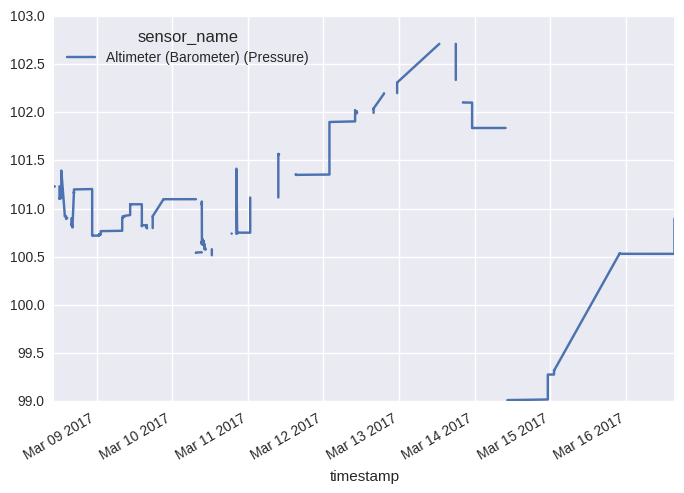

In [126]:
sub.iloc[:, 3:4].plot()

In [64]:
def add_acceleration_magnitude(df):
    "Adds Acceleration magnitude to a dataframe. First 3 columns must be acceleration vectors. Must be 3D."
    from math import sqrt

    accel_mag = []
    
    for row in range(len(df)):
        accel_mag.append(sqrt(df.iloc[row, 0]**2 + df.iloc[row, 1]**2 + df.iloc[row, 2]**2))

    df['accel_mag'] = accel_mag
    return 'finished!'

In [65]:
add_acceleration_magnitude(sub)

'finished!'

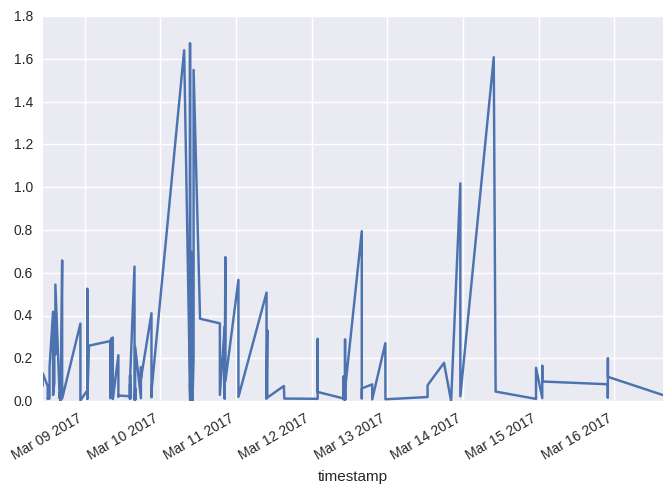

In [67]:
sub['accel_mag'].plot()